<a href="https://colab.research.google.com/github/shababusama/Deep_Learning_Techniques_for_Brain_Tumor_Classification_in_MRI_Images/blob/main/Brain_Tumor_Classification_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
#---------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Importing the Images from Google Drive

In [2]:
def create_training_dataframe(training_path):
    """
    Creates a DataFrame containing the class labels and corresponding image paths from the given training directory.

    Parameters:
    training_path (str): Path to the directory containing subdirectories of images, where each subdirectory is named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Class Label'.
    """
    class_labels, image_paths = zip(*[
        (label, os.path.join(training_path, label, image))
        for label in os.listdir(training_path) if os.path.isdir(os.path.join(training_path, label))
        for image in os.listdir(os.path.join(training_path, label))
    ])

    training_df = pd.DataFrame({'Image Path': image_paths, 'Class Label': class_labels})
    return training_df

def create_test_dataframe(test_path):
    """
    Creates a DataFrame containing the class labels and corresponding image paths from the given test directory.

    Parameters:
    test_path (str): Path to the directory containing subdirectories of images, where each subdirectory is named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Class Label'.
    """
    class_labels, image_paths = zip(*[
        (label, os.path.join(test_path, label, image))
        for label in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, label))
        for image in os.listdir(os.path.join(test_path, label))
    ])

    test_df = pd.DataFrame({'Image Path': image_paths, 'Class Label': class_labels})
    return test_df

In [3]:
tr_df = create_training_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Training')

In [4]:
tr_df

,Image Path,Class Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
...,...,...
5707,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5708,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5709,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5710,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma


In [5]:
ts_df = create_training_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing')

In [6]:
ts_df

,Image Path,Class Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
...,...,...
1306,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1307,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1308,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1309,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary


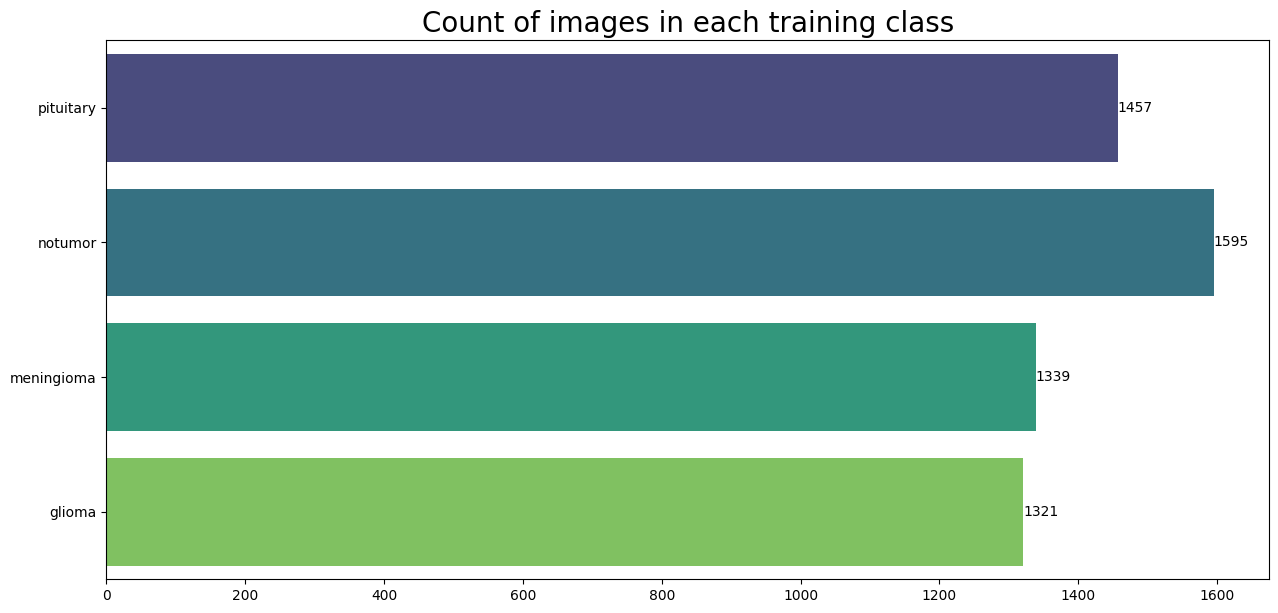

In [7]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, y='Class Label', palette='viridis')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each training class', fontsize=20)

# Adding the labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.show()

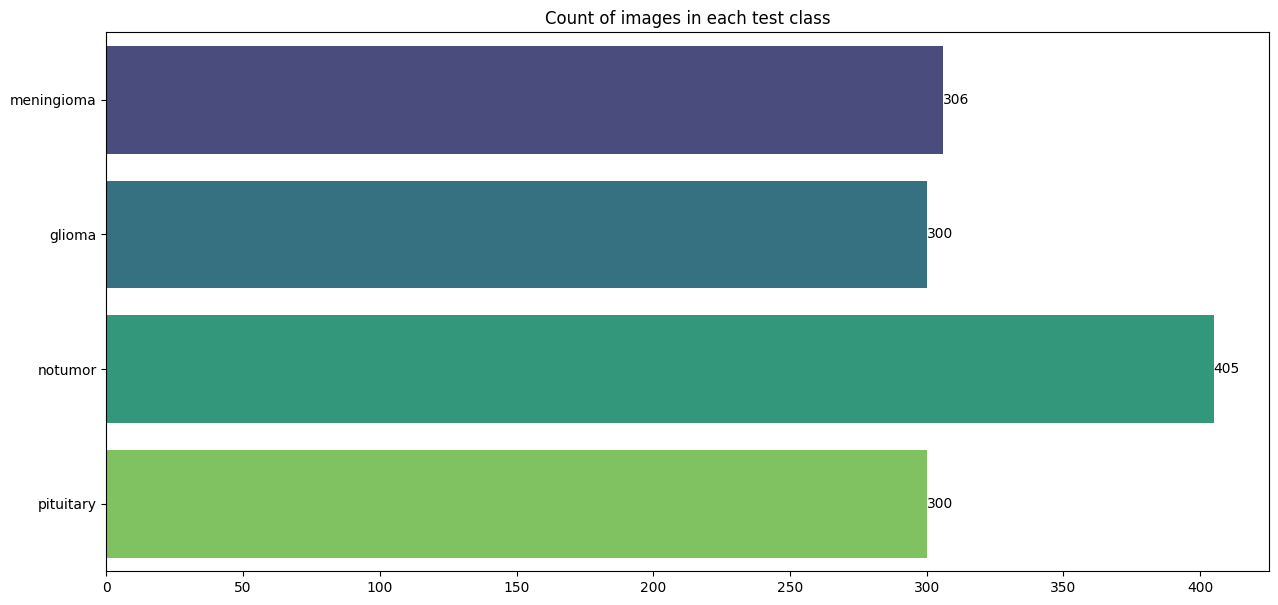

In [8]:
# Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class Label'], data =ts_df, palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each test class')
# Adding the labels to the bars
for container in ax.containers:
    ax.bar_label(container)


plt.show()

# Data Preprocessing

Data Spliting to training testing and validation set

In [9]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class Label'])

In [10]:
# Parameters
batch_size = 32
img_size = (224, 224)
brightness_range = (0.8, 1.2)
rescale_factor = 1/255

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(
    rescale=rescale_factor,
    brightness_range=brightness_range
)

test_gen = ImageDataGenerator(rescale=rescale_factor)

# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size
    )

    valid_gen = train_val_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size
    )

    test_gen_flow = test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=16,
        target_size=img_size,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen_flow

# Assuming tr_df, valid_df, ts_df are defined and not empty
train_gen, valid_gen, test_gen_flow = create_generators(tr_df, valid_df, ts_df, batch_size, img_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Getting samples from data

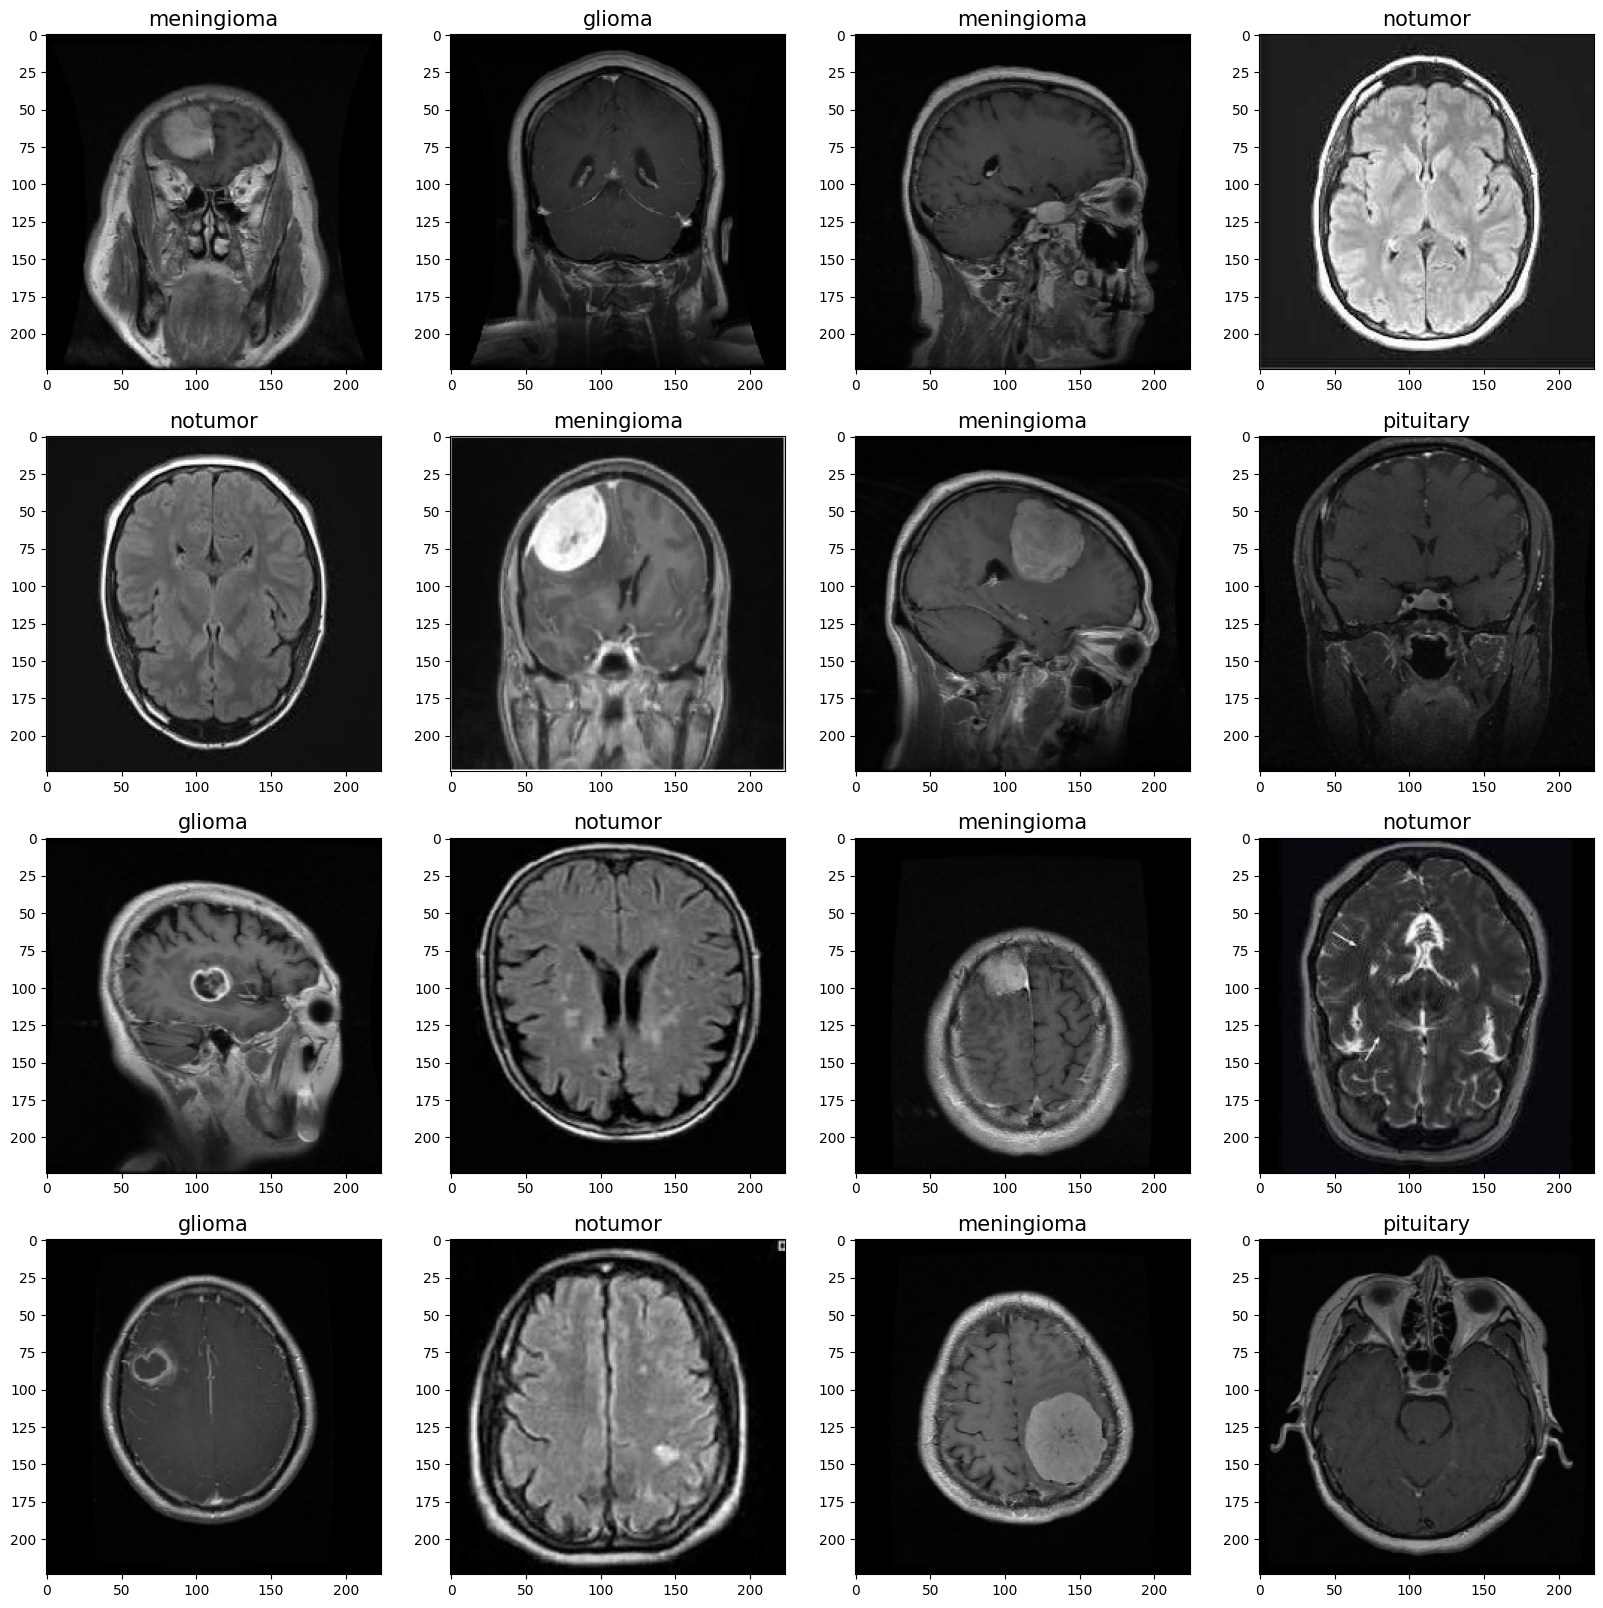

In [11]:
# Get class indices from the training generator
class_dict = train_gen.class_indices
# Create a list of class names from the dictionary keys
classes = list(class_dict.keys())
# Fetch the next batch of images and labels from the test generator
images, labels = next(test_gen_flow)

# Set the figure size for the plot
plt.figure(figsize=(20, 20))

# Iterate over the images and their corresponding labels
for i, (image, label) in enumerate(zip(images, labels)):
    # Create a subplot in a 4x4 grid
    plt.subplot(4, 4, i + 1)
    # Display the image
    plt.imshow(image)
    # Find the index of the highest value in the one-hot encoded label
    class_name = classes[np.argmax(label)]
    # Set the title of the subplot to the class name
    plt.title(class_name, color='k', fontsize=15)

# Display the figure with all subplots
plt.show()

# CNN Model Design

In [12]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    # Block 1
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 2
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 3
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 4
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 5
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.2),  # Adding Dropout
    Dense(64, activation="relu"),
    Dropout(0.2),  # Adding Dropout
    Dense(class_count, activation="softmax")
])


In [13]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

# Training the Network

In [14]:
epochs = 15   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
179/179 [==============================] - 1641s 9s/step - loss: 1.3316 - accuracy: 0.6199 - val_loss: 1.4080 - val_accuracy: 0.3069
Epoch 2/15
179/179 [==============================] - 131s 729ms/step - loss: 0.6386 - accuracy: 0.7617 - val_loss: 2.6064 - val_accuracy: 0.2931
Epoch 3/15
179/179 [==============================] - 131s 733ms/step - loss: 0.5514 - accuracy: 0.7988 - val_loss: 1.9539 - val_accuracy: 0.4534
Epoch 4/15
179/179 [==============================] - 130s 726ms/step - loss: 0.4781 - accuracy: 0.8220 - val_loss: 0.6592 - val_accuracy: 0.7435
Epoch 5/15
179/179 [==============================] - 130s 727ms/step - loss: 0.4253 - accuracy: 0.8531 - val_loss: 2.4594 - val_accuracy: 0.5130
Epoch 6/15
179/179 [==============================] - 131s 729ms/step - loss: 0.3708 - accuracy: 0.8689 - val_loss: 1.2780 - val_accuracy: 0.6504
Epoch 7/15
179/179 [==============================] - 131s 733ms/step - loss: 0.3325 - accuracy: 0.8755 - val_loss: 0.8078 - v

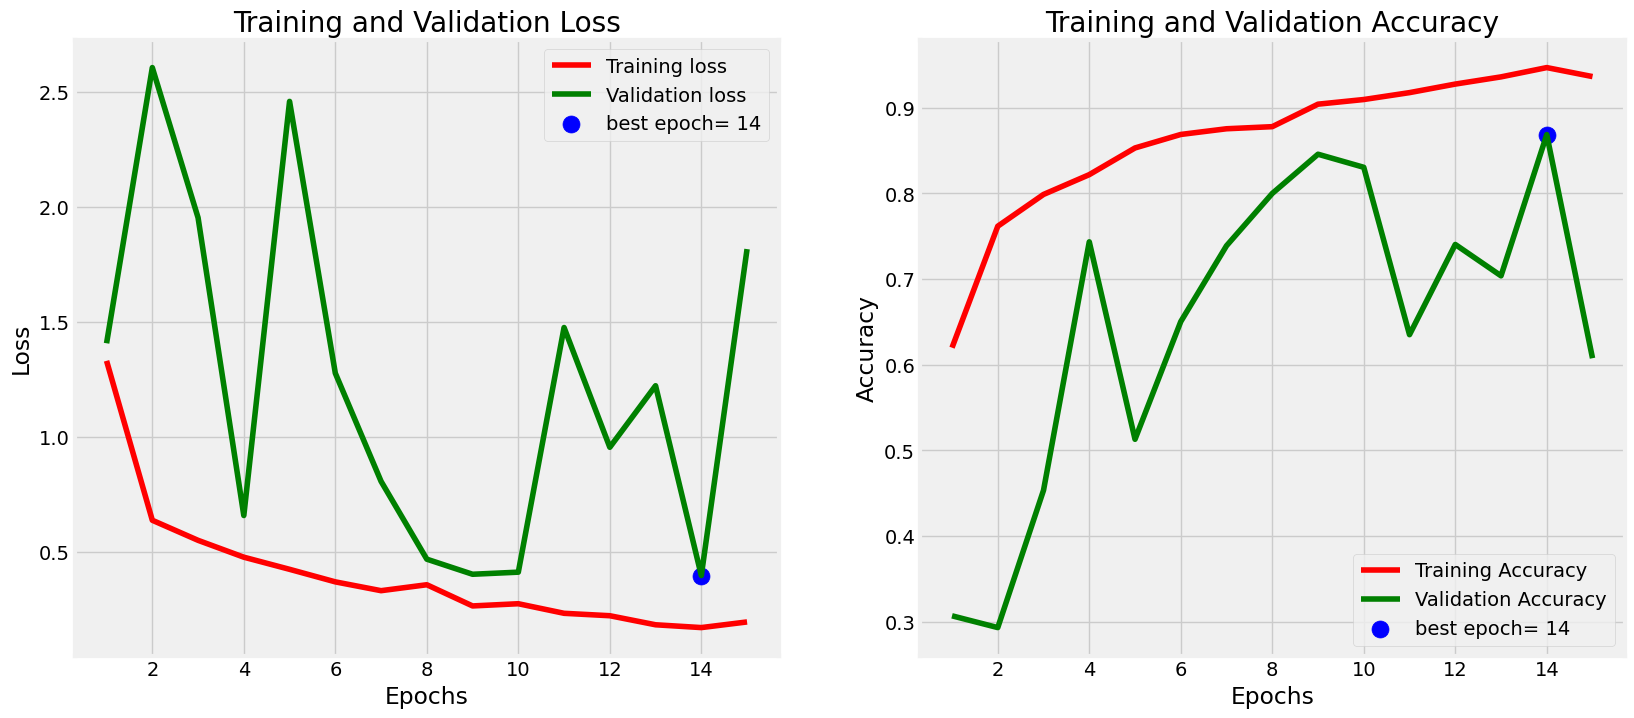

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()